In [1]:
import pandas as pd  # Library untuk manipulasi data dalam bentuk DataFrame
import numpy as np  # Library untuk komputasi numerik, operasi array, dan matriks
import matplotlib.pyplot as plt  # Library untuk membuat visualisasi grafik
import seaborn as sns  # Library untuk visualisasi data statistik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV  # Fungsi untuk membagi data dan mencari hyperparameter terbaik
from sklearn.linear_model import LogisticRegression  # Model klasifikasi berbasis regresi logistik
from sklearn.ensemble import RandomForestClassifier  # Model klasifikasi berbasis Random Forest (ensemble dari pohon keputusan)
from sklearn.svm import SVC  # Support Vector Classifier, digunakan untuk klasifikasi
from sklearn.neighbors import KNeighborsClassifier  # Model klasifikasi k-Nearest Neighbors (KNN)
from xgboost import XGBClassifier  # Model XGBoost untuk klasifikasi
from sklearn.neural_network import MLPClassifier  # Model Neural Networks (Multi-layer Perceptron) untuk klasifikasi
from yellowbrick.classifier import ROCAUC  # Visualisasi ROC curve dari library Yellowbrick
from imblearn.over_sampling import SMOTE  # Teknik untuk menangani data yang tidak seimbang dengan oversampling kelas minoritas
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score  # Evaluasi model seperti ROC curve, AUC, precision, recall, dan akurasi
import plotly.express as px
from sklearn.metrics import confusion_matrix
import kagglehub
import joblib
import os
from xgboost import plot_importance

In [2]:
# Download latest version
path = kagglehub.dataset_download("wilmanufatimah22/near-earth-object-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/near-earth-object-dataset


In [3]:
# Path ke direktori dataset
dataset_path = '/kaggle/input/near-earth-object-dataset'

# List file dalam direktori
print("File dalam direktori:")
print(os.listdir(dataset_path))

File dalam direktori:
['data_preprocessed.csv']


In [4]:
# Path ke direktori dataset
dataset_path = '/kaggle/input/near-earth-object-dataset'

# Nama file dataset
file_name = 'data_preprocessed.csv'

# Membaca file CSV
df = pd.read_csv(f'{dataset_path}/{file_name}')

# Tampilkan beberapa baris pertama dari dataset
print("Dataset Preview:")
df.head()

Dataset Preview:


,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,moid
0,-1.404852,1.458702,1.572803,0.816947,0.813685,0,0.105261
1,-1.628087,2.083379,2.152058,2.280802,0.701647,1,0.030238
2,-0.599112,0.075635,0.147109,-0.979324,1.247151,0,0.059966
3,-0.885132,0.436994,0.542769,1.090705,-0.513372,0,0.154436
4,-0.163105,-0.288098,-0.272000,0.215038,1.051623,0,0.034305


In [5]:
# Memisahkan kolom fitur dan target
X = df.drop(columns=['is_hazardous']) # Fitur
y = df['is_hazardous'] # Target

In [6]:
# Menangani data yang tidak seimbang pada kolom target (is hazardous)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Original y distribution: {y.value_counts()}')
print(f'Resampled y distribution: {pd.Series(y_resampled).value_counts()}')

Original y distribution: is_hazardous
0    267017
1     35632
Name: count, dtype: int64
Resampled y distribution: is_hazardous
0    267017
1    267017
Name: count, dtype: int64


In [7]:
# Membagi data menjadi data training dan data test dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Melihat jumlah data pada training set dan test set
print(f'Jumlah data pada training set (X_train): {len(X_train)}')
print(f'Jumlah data pada test set (X_test): {len(X_test)}')
print(f'Jumlah label pada training set (y_train): {len(y_train)}')
print(f'Jumlah label pada test set (y_test): {len(y_test)}')

Jumlah data pada training set (X_train): 427227
Jumlah data pada test set (X_test): 106807
Jumlah label pada training set (y_train): 427227
Jumlah label pada test set (y_test): 106807


In [8]:
# Membangun model dasar
model_LG_baseline = LogisticRegression()
model_LG_baseline.fit(X_train, y_train)

# Evaluasi model dasar
y_pred_baseline = model_LG_baseline.predict(X_test)
print("LogisticRegression Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, model_LG_baseline.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy_baseline}")
print(f"ROC AUC: {roc_auc_baseline}")

LogisticRegression Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     53361
           1       0.96      0.99      0.97     53446

    accuracy                           0.97    106807
   macro avg       0.97      0.97      0.97    106807
weighted avg       0.97      0.97      0.97    106807

Accuracy: 0.972014942840825
ROC AUC: 0.9960206463631938


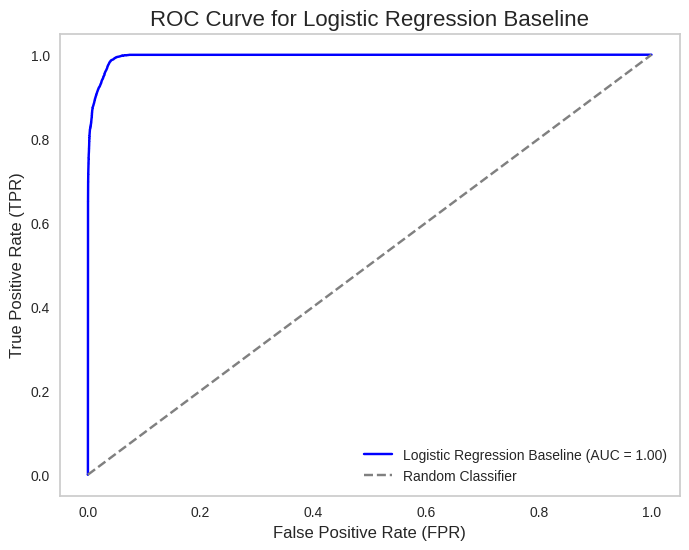

In [9]:
# Menghitung probabilitas untuk kelas positif
y_prob_baseline = model_LG_baseline.predict_proba(X_test)[:, 1]

# Menghitung kurva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_baseline)
roc_auc = auc(fpr, tpr)

# Membuat plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression Baseline (AUC = {roc_auc:.2f})')

# Menambahkan garis diagonal untuk baseline (model random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Pengaturan plot
plt.title('ROC Curve for Logistic Regression Baseline', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Confusion Matrix:
[[50884  2477]
 [  512 52934]]


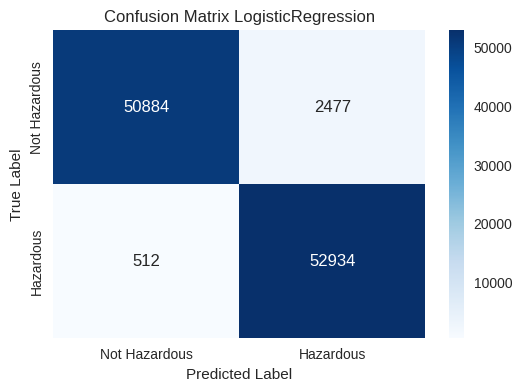

In [10]:
# Confusion Matrix
conf_matrix_LG = confusion_matrix(y_test, y_pred_baseline)
print("Confusion Matrix:")
print(conf_matrix_LG)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_LG, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix LogisticRegression')
plt.show()

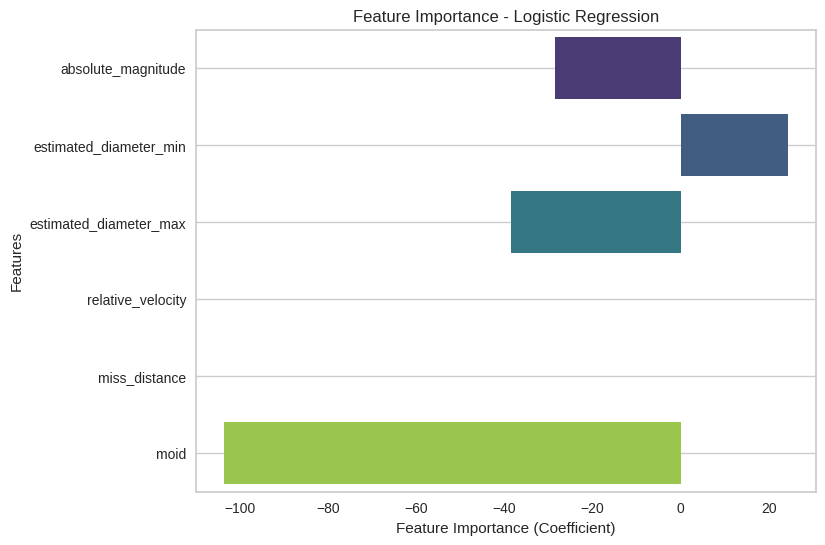

In [11]:
# Menampilkan koefisien fitur
feature_importance = model_LG_baseline.coef_[0]
features = X_train.columns

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=features, palette='viridis')
plt.xlabel('Feature Importance (Coefficient)')
plt.ylabel('Features')
plt.title('Feature Importance - Logistic Regression')
plt.grid()
plt.show()

In [12]:
# Menyimpan model ke direktori /kaggle/working/
joblib.dump(model_LG_baseline, '/kaggle/working/model_LG_baseline.pkl')

# Diunduh di tab Output

['/kaggle/working/model_LG_baseline.pkl']

In [13]:
# Membangun model dasar RandomForest
model_rf_baseline = RandomForestClassifier(random_state=42)
model_rf_baseline.fit(X_train, y_train)

# Evaluasi model dasar
y_pred_rf_baseline = model_rf_baseline.predict(X_test)
y_prob_rf_baseline = model_rf_baseline.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif

# Menampilkan hasil evaluasi
print("Random Forest Baseline Model Performance:")
print(classification_report(y_test, y_pred_rf_baseline))

accuracy_rf_baseline = accuracy_score(y_test, y_pred_rf_baseline)
roc_auc_rf_baseline = roc_auc_score(y_test, y_prob_rf_baseline)

print(f"Accuracy: {accuracy_rf_baseline}")
print(f"ROC AUC: {roc_auc_rf_baseline}")

Random Forest Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53361
           1       1.00      1.00      1.00     53446

    accuracy                           1.00    106807
   macro avg       1.00      1.00      1.00    106807
weighted avg       1.00      1.00      1.00    106807

Accuracy: 0.9996161300289307
ROC AUC: 0.9999993232657736


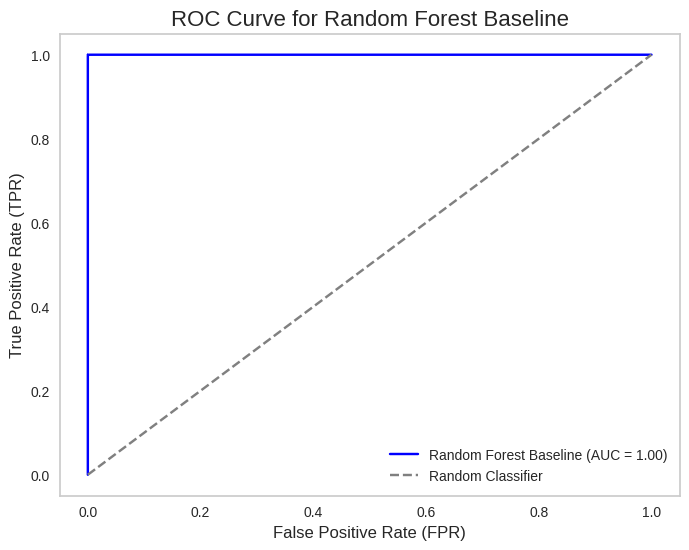

In [14]:
# Menghitung kurva ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf_baseline)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Membuat plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest Baseline (AUC = {roc_auc_rf:.2f})')

# Menambahkan garis diagonal untuk baseline (model random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Pengaturan plot
plt.title('ROC Curve for Random Forest Baseline', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Confusion Matrix:
[[53353     8]
 [   33 53413]]


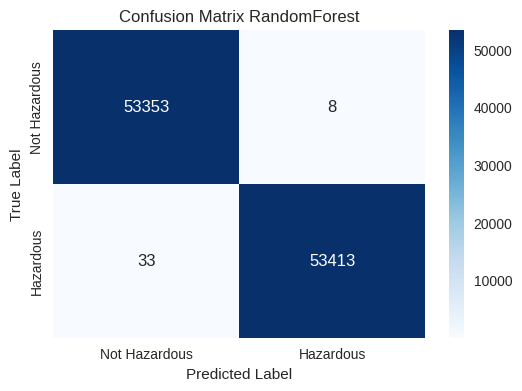

In [15]:
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_baseline)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Hazardous', 'Hazardous'], 
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix RandomForest')
plt.show()

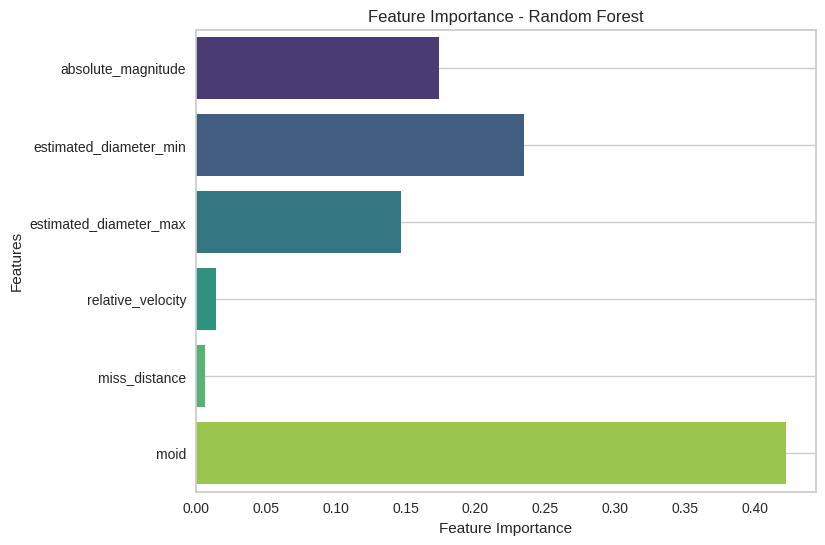

In [16]:
# Menampilkan koefisien fitur
feature_importance = model_rf_baseline.feature_importances_
features = X_train.columns

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=features, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.grid()
plt.show()

In [17]:
# Menyimpan model ke direktori /kaggle/working/
joblib.dump(model_rf_baseline, '/kaggle/working/model_rf_baseline.pkl')

# Diunduh di tab Output

['/kaggle/working/model_rf_baseline.pkl']

In [18]:
# Membangun model dasar XGBoost
model_xgb_baseline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_baseline.fit(X_train, y_train)

# Evaluasi model dasar
y_pred_xgb_baseline = model_xgb_baseline.predict(X_test)
y_prob_xgb_baseline = model_xgb_baseline.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif

# Menampilkan hasil evaluasi
print("XGBoost Baseline Model Performance:")
print(classification_report(y_test, y_pred_xgb_baseline))

accuracy_xgb_baseline = accuracy_score(y_test, y_pred_xgb_baseline)
roc_auc_xgb_baseline = roc_auc_score(y_test, y_prob_xgb_baseline)

print(f"Accuracy: {accuracy_xgb_baseline}")
print(f"ROC AUC: {roc_auc_xgb_baseline}")

XGBoost Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53361
           1       1.00      1.00      1.00     53446

    accuracy                           1.00    106807
   macro avg       1.00      1.00      1.00    106807
weighted avg       1.00      1.00      1.00    106807

Accuracy: 0.9989888303201101
ROC AUC: 0.9999941211782172


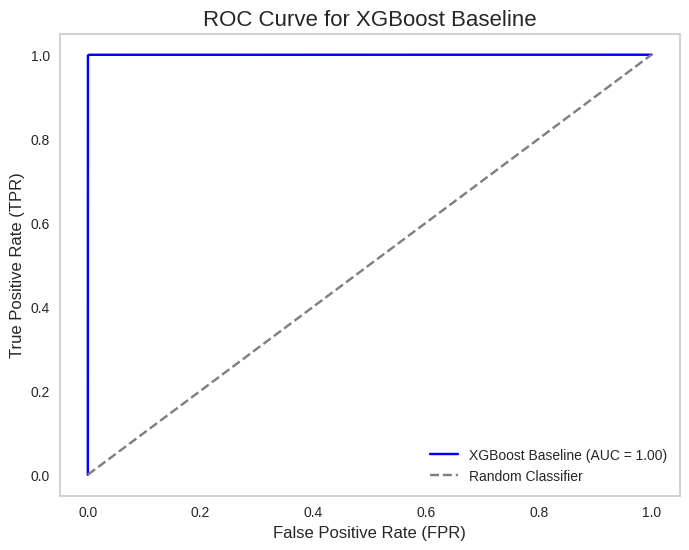

In [19]:
# Menghitung kurva ROC untuk XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb_baseline)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Membuat plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'XGBoost Baseline (AUC = {roc_auc_xgb:.2f})')

# Menambahkan garis diagonal untuk baseline (model random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Pengaturan plot
plt.title('ROC Curve for XGBoost Baseline', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Confusion Matrix:
[[53319    42]
 [   66 53380]]


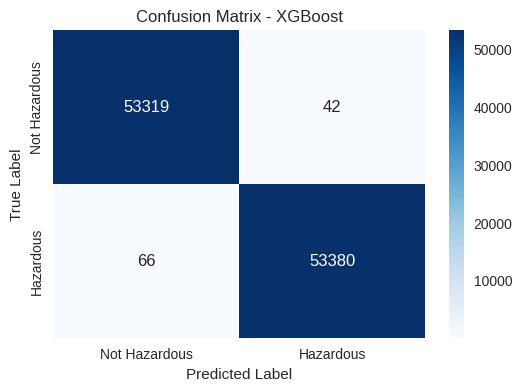

In [20]:
# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb_baseline)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Hazardous', 'Hazardous'], 
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()

<Figure size 1000x800 with 0 Axes>

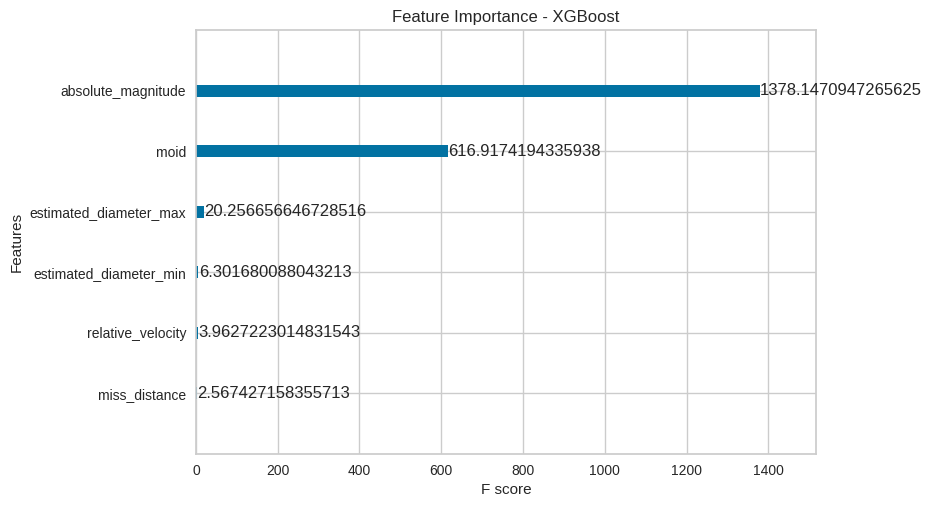

In [21]:
# Menampilkan feature importance
plt.figure(figsize=(10, 8))
plot_importance(model_xgb_baseline, importance_type='gain', title='Feature Importance - XGBoost')
plt.show()

In [22]:
# Menyimpan model ke direktori /kaggle/working/
joblib.dump(model_xgb_baseline, '/kaggle/working/model_xgb_baseline.pkl')

# Diunduh di tab Output

['/kaggle/working/model_xgb_baseline.pkl']

In [23]:
# Membangun model dasar K-Nearest Neighbors (KNN)
model_knn_baseline = KNeighborsClassifier()
model_knn_baseline.fit(X_train, y_train)

# Evaluasi model dasar
y_pred_knn_baseline = model_knn_baseline.predict(X_test)
y_prob_knn_baseline = model_knn_baseline.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif

# Menampilkan hasil evaluasi
print("KNN Baseline Model Performance:")
print(classification_report(y_test, y_pred_knn_baseline))

accuracy_knn_baseline = accuracy_score(y_test, y_pred_knn_baseline)
roc_auc_knn_baseline = roc_auc_score(y_test, y_prob_knn_baseline)

print(f"Accuracy: {accuracy_knn_baseline}")
print(f"ROC AUC: {roc_auc_knn_baseline}")

KNN Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     53361
           1       0.94      1.00      0.97     53446

    accuracy                           0.97    106807
   macro avg       0.97      0.97      0.97    106807
weighted avg       0.97      0.97      0.97    106807

Accuracy: 0.965779396481504
ROC AUC: 0.9889770969525702


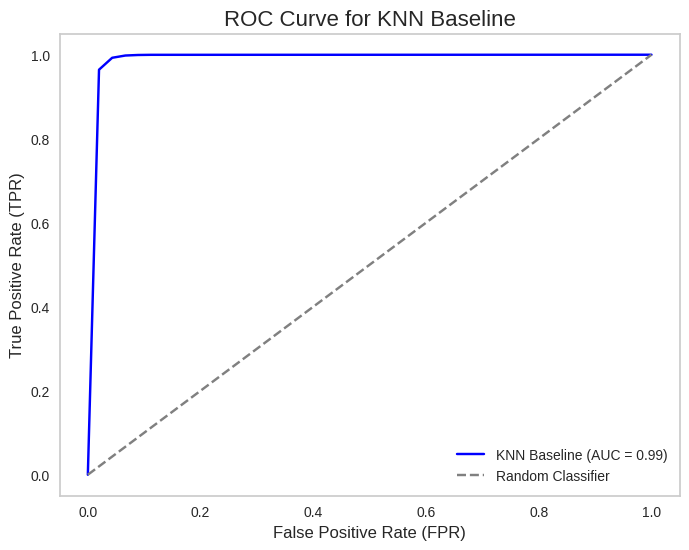

In [24]:
# Menghitung kurva ROC untuk KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn_baseline)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Membuat plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', label=f'KNN Baseline (AUC = {roc_auc_knn:.2f})')

# Menambahkan garis diagonal untuk baseline (model random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Pengaturan plot
plt.title('ROC Curve for KNN Baseline', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Confusion Matrix:
[[49808  3553]
 [  102 53344]]


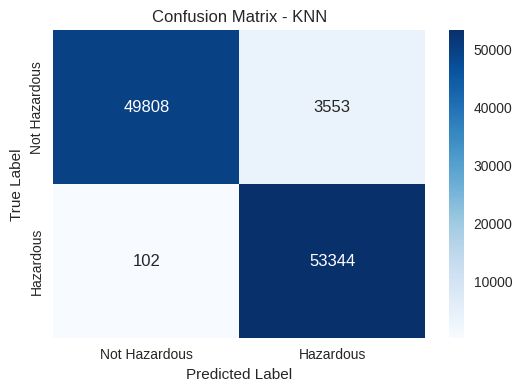

In [25]:
# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn_baseline)
print("Confusion Matrix:")
print(conf_matrix_knn)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Hazardous', 'Hazardous'], 
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

In [26]:
# Menyimpan model ke direktori /kaggle/working/
joblib.dump(model_knn_baseline, '/kaggle/working/model_knn_baseline.pkl')

# Diunduh di tab Output

['/kaggle/working/model_knn_baseline.pkl']

In [27]:
# Membangun model dasar MLP
model_mlp_baseline = MLPClassifier(random_state=42, max_iter=500)
model_mlp_baseline.fit(X_train, y_train)

# Evaluasi model dasar
y_pred_mlp_baseline = model_mlp_baseline.predict(X_test)
y_prob_mlp_baseline = model_mlp_baseline.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif

# Menampilkan hasil evaluasi
print("MLP Baseline Model Performance:")
print(classification_report(y_test, y_pred_mlp_baseline))

accuracy_mlp_baseline = accuracy_score(y_test, y_pred_mlp_baseline)
roc_auc_mlp_baseline = roc_auc_score(y_test, y_prob_mlp_baseline)

print(f"Accuracy: {accuracy_mlp_baseline}")
print(f"ROC AUC: {roc_auc_mlp_baseline}")

MLP Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     53361
           1       1.00      1.00      1.00     53446

    accuracy                           1.00    106807
   macro avg       1.00      1.00      1.00    106807
weighted avg       1.00      1.00      1.00    106807

Accuracy: 0.9952812081605138
ROC AUC: 0.999909628630887


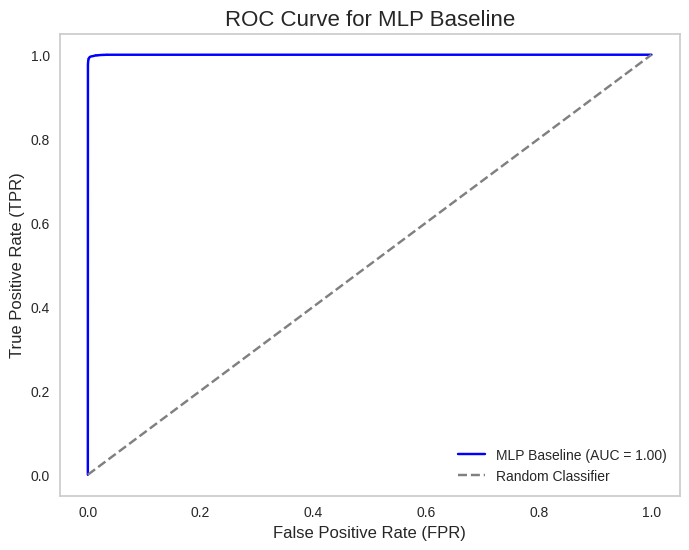

In [28]:
# Menghitung kurva ROC untuk MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_prob_mlp_baseline)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Membuat plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='blue', label=f'MLP Baseline (AUC = {roc_auc_mlp:.2f})')

# Menambahkan garis diagonal untuk baseline (model random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Pengaturan plot
plt.title('ROC Curve for MLP Baseline', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Confusion Matrix:
[[53094   267]
 [  237 53209]]


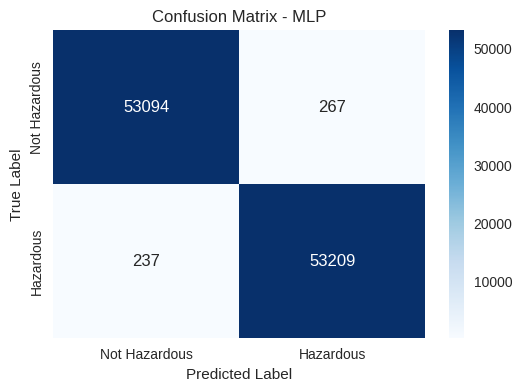

In [29]:
# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp_baseline)
print("Confusion Matrix:")
print(conf_matrix_mlp)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Hazardous', 'Hazardous'], 
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MLP')
plt.show()

In [30]:
# Menyimpan model ke direktori /kaggle/working/
joblib.dump(model_mlp_baseline, '/kaggle/working/model_mlp_baseline.pkl')

# Diunduh di tab Output

['/kaggle/working/model_mlp_baseline.pkl']